<a href="https://colab.research.google.com/github/FulISun/AI_ML-DL_Intermediate/blob/main/machine_learing/05_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# scikit-learn을 이용한 앙상블 메소드

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd

cm2 = ListedColormap(['C1', 'C2'])
cm3 = ListedColormap(['C1', 'C2', 'C3'])

## 다수결 방식 Voting

- 여러 학습기를 개별 학습시키고 각 학습기의 예측 결과를 다수결로 취합하는 방식

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()
X, y = iris.data[:,[1,2]], iris.target

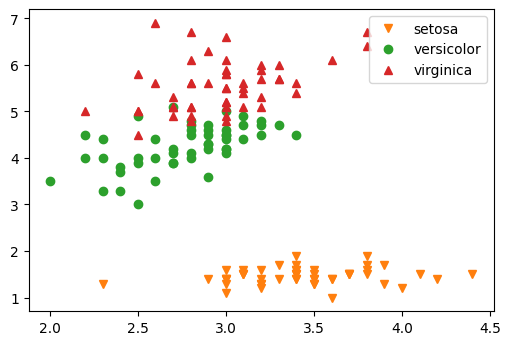

In [ ]:
fig = plt.figure(dpi=100)
ax = plt.axes()

ax.plot(X[y==0][:,0], X[y==0][:,1], 'v', color='C1', label = 'setosa')
ax.plot(X[y==1][:,0], X[y==1][:,1], 'o', color='C2', label = 'versicolor')
ax.plot(X[y==2][:,0], X[y==2][:,1], '^', color='C3', label = 'virginica')

ax.legend()
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import VotingClassifier

In [ ]:
from sklearn.model_selection import cross_validate

- 학습기 세 개를 만들어 각각 학습
- votingClassifier에 위에서 사용한 학습기 세 개를 주고 각각 학습하여 다수결로 예측 생성

In [ ]:
logreg = LogisticRegression(C = 0.01, random_state = 66 )
tree = DecisionTreeClassifier(max_depth=2, random_state=100)
knn = KNeighborsClassifier(n_neighbors=1)

vote = VotingClassifier(
    estimators=[
        ('logreg', logreg),
        ('tree', tree),
        ('knn', knn)
    ], voting='hard'
)

for clf, name in zip([logreg, tree, knn, vote],
                     ['Logistic Regression', 'Decision tree', 'KNN', 'Vote']):
  
    # 학습 데이터를 10조각으로 쪼개서 9조각에 대해서 학습하고 나머지 1조각에 대해서 예측하기를 10번 반복
    cv_results = cross_validate(clf, X, y, cv=10, return_estimator=True)
    scores = cv_results["test_score"]
    print("Accuracy score via cross-validation: "
          f"{scores.mean():.3f} +/- {scores.std():.3f} [{name}]")
    

Accuracy score via cross-validation: 0.840 +/- 0.080 [Logistic Regression]
Accuracy score via cross-validation: 0.947 +/- 0.050 [Decision tree]
Accuracy score via cross-validation: 0.920 +/- 0.072 [KNN]
Accuracy score via cross-validation: 0.953 +/- 0.052 [Vote]


## 앙상블 방법 개요

- 이진 분류 문제에서 

- 적어도 50%이상은 맞추는 분류기 $n$개가 있으면

- 모두에게 물어보고 과반 이상이 틀려야 틀렸다고 판단

- 또는 과반이상 맞춰야 맞췄다고 판단

- 예를 들어 맞출 확률이 58% 밖에 안되는 예측기가 있다고 하면 이 예측기 하나를 사용해서 이진분류 문제를 풀면 42%는 틀림

- 거의 두번에 한번은 틀리는 무작위 찍기에 가까움

- 그런데 이런 분류기 100개를 만들고 100개 한테 다 물어보면?

- 이진분류 문제를 풀 때 0과 1중에서 1을 출력할 확률 $p=0.58$이고 100개 중 적어도 51개가 1을 출력하면 다수결에 의해 최종적으로 1이라 판단

- 이런 문제를 모델링하는 확률분포는 이항분포이므로 이항분포 확률질량함수를 써서 계산해보면

$$
P(x \ge 51) = \sum_{k=51}^{100} {100 \choose k} 0.58^k (1-0.58)^{100-k}
$$

- 위 식에서 ${100 \choose k}$는 다음처럼 계산

$$
{100 \choose k} = \frac{100!}{(100-k)!k!}
$$

- $n!$은 팩토리얼factorial로 읽고 다음처럼 계산

$$
n! = n \times n-1 \times n-2 \times \cdots \times 2 \times 1
$$

In [ ]:
import math

# 파이썬으로 계산
p = 0.0

for k in range(51, 101):
    c = math.factorial(100)/(math.factorial(100-k)*math.factorial(k))
    p += c*0.58**k * (1-0.58)**(100-k)

print(p)

0.9350224546534118


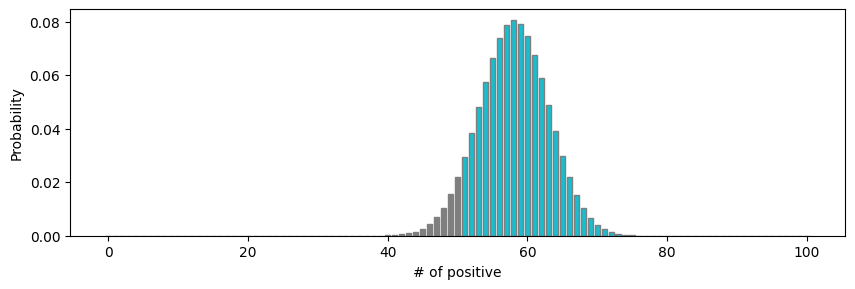

In [ ]:
# 시뮬레이션
from scipy.stats import binom

# 58% 이진분류기 100개
ensemble_clf = binom(n=100, p=0.58)

# 이 100개 중 몇 개나 1이라고 예축하는지 확률적으로 그리기
fig = plt.figure(figsize=(10,3), dpi=100)
ax = plt.axes()

ax.bar(np.arange(51), ensemble_clf.pmf(np.arange(51)), 
       color='C7', edgecolor='C7' )
ax.bar(np.arange(51, 101), ensemble_clf.pmf(np.arange(51, 101)), 
       color='C9', edgecolor='C7' )
ax.set_xlabel("# of positive")
ax.set_ylabel("Probability")

plt.show()

In [ ]:
# 그 100개를 가지고 100번 분류해보면 100번중 몇 번이나 맞출까?
ret = ensemble_clf.rvs(size=100)

predict = np.zeros(100, dtype=int)
predict[ret>50] = 1
print(np.c_[ret, predict])
print(f"{predict.sum()}번 1로 판단")

[[53  1]
 [55  1]
 [54  1]
 [49  0]
 [56  1]
 [53  1]
 [63  1]
 [63  1]
 [54  1]
 [60  1]
 [69  1]
 [54  1]
 [55  1]
 [53  1]
 [47  0]
 [55  1]
 [55  1]
 [46  0]
 [63  1]
 [58  1]
 [51  1]
 [58  1]
 [50  0]
 [52  1]
 [68  1]
 [59  1]
 [57  1]
 [55  1]
 [56  1]
 [58  1]
 [57  1]
 [54  1]
 [64  1]
 [63  1]
 [45  0]
 [58  1]
 [58  1]
 [53  1]
 [59  1]
 [53  1]
 [65  1]
 [65  1]
 [53  1]
 [60  1]
 [62  1]
 [50  0]
 [58  1]
 [65  1]
 [45  0]
 [57  1]
 [62  1]
 [49  0]
 [53  1]
 [55  1]
 [67  1]
 [44  0]
 [55  1]
 [56  1]
 [62  1]
 [58  1]
 [55  1]
 [63  1]
 [56  1]
 [71  1]
 [59  1]
 [64  1]
 [56  1]
 [59  1]
 [68  1]
 [56  1]
 [62  1]
 [58  1]
 [54  1]
 [59  1]
 [58  1]
 [60  1]
 [54  1]
 [55  1]
 [67  1]
 [56  1]
 [54  1]
 [65  1]
 [56  1]
 [64  1]
 [68  1]
 [58  1]
 [51  1]
 [60  1]
 [54  1]
 [53  1]
 [60  1]
 [62  1]
 [62  1]
 [57  1]
 [62  1]
 [59  1]
 [57  1]
 [63  1]
 [61  1]
 [56  1]]
91번 1로 판단


## 배깅Bagging(Bootstrap Aggregating)

### 부트스트랩

- 데이터셋으로터 샘플을 복원 추출하여 새로운 데이터셋을 만들어냄
- 복원추출은 추출한 것을 다시 넣고 뽑기를 반복하는 방법. 그래서 중복되어 뽑히게 됨
- 이렇게 복원추출을 하면 전체 데이터의 약 64% 정도가 샘플링 됨 (여러 번 뽑히는 샘플이 있는 반면 한 번도 안 뽑히는 샘플도 있기 때문임)

In [ ]:
# 데이터 복원추출
X = np.random.rand(100)

X_boot = np.random.choice(X, X.shape[0], replace=True)
print(len(set(X_boot))) # set이라는 함수에 넣어서 집합으로 만듦. 집합은 중복 허용 안 하므로 하나씩만 남음.
# 61 -> 원 데이터에서 61종류의 값만 뽑힌 것임.

61


In [ ]:
m_ = 100
# 안 뽑힐 확률
1 - (1-(1/m_))**m_

0.6339676587267709

- 이렇게 복원추출된 조금씩 다른 다양한 데이터셋에 대해서 개별 예측기를 학습시키고 위에서 알아본 것처럼 예측의 평균 또는 다수결 투표로 최종 예측을 하게 됨
- 개별 예측기는 아무 예측기나 가능하나 Decision tree를 많이 사용함

### 데이터 생성

In [ ]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)

### 데이터 확인

In [ ]:
print(X.shape, y.shape)

(100, 2) (100,)


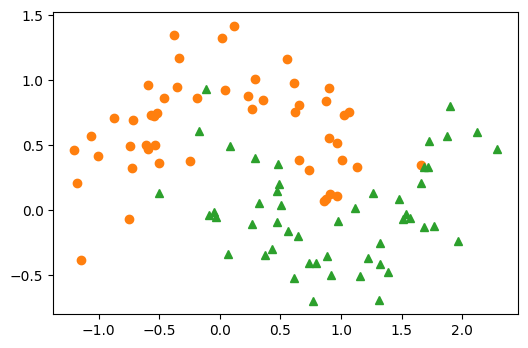

In [ ]:
fig = plt.figure(dpi=100)
ax = plt.axes()

ax.plot(X[y==0][:, 0], X[y==0][:, 1], 'o', color='C1')
ax.plot(X[y==1][:, 0], X[y==1][:, 1], '^', color='C2')

plt.show()

### 학습

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# 분류기 개수
N = 30

In [ ]:
idx = np.arange(X.shape[0])
idx_boot = np.random.choice(idx, X.shape[0], replace=True)
idx_boot # 인덱스임. 즉 X의 32번째 데이터, 29번째 데이터....~

array([17,  8, 18, 14, 98, 23, 28, 49, 72, 49, 33, 39, 44, 60, 56, 60, 58,
       70, 34, 12, 27, 69, 93, 25, 68,  7, 95, 55, 46, 66, 48, 93, 59, 97,
       70, 79, 30, 82, 44, 55, 33,  5, 98, 48, 24, 87, 35, 83, 49, 49, 72,
       54, 39, 13, 25, 72, 96, 12,  3, 47, 57, 24, 24, 57, 89, 87, 28, 85,
       24, 94, 16, 26,  4, 15, 35, 55, 20, 97,  8, 98, 48, 44, 35, 75,  1,
       80, 40, 37, 47, 88, 70, 99, 89, 21, 47, 66, 79, 62, 66, 29])

In [ ]:
# 배깅 직접 구현하기

# 데이터를 직접 추출하지 않고 데이터의 인덱스를 만들고 인덱스를 추출하기
idx = np.arange(X.shape[0])
ests = []

for i in range(N): 
    # 데이터 복원추출
    idx_boot = np.random.choice(idx, X.shape[0], replace=True)
    X_boot = X[idx_boot] # 인덱스로 추출
    y_boot = y[idx_boot] # 인덱스로 추출

    ests.append( DecisionTreeClassifier(max_depth = 5) )

    ests[-1].fit(X_boot, y_boot)

In [ ]:
ests

[DecisionTreeClassifier(max_depth=5),
 DecisionTreeClassifier(max_depth=5),
 DecisionTreeClassifier(max_depth=5),
 DecisionTreeClassifier(max_depth=5),
 DecisionTreeClassifier(max_depth=5),
 DecisionTreeClassifier(max_depth=5),
 DecisionTreeClassifier(max_depth=5),
 DecisionTreeClassifier(max_depth=5),
 DecisionTreeClassifier(max_depth=5),
 DecisionTreeClassifier(max_depth=5),
 DecisionTreeClassifier(max_depth=5),
 DecisionTreeClassifier(max_depth=5),
 DecisionTreeClassifier(max_depth=5),
 DecisionTreeClassifier(max_depth=5),
 DecisionTreeClassifier(max_depth=5),
 DecisionTreeClassifier(max_depth=5),
 DecisionTreeClassifier(max_depth=5),
 DecisionTreeClassifier(max_depth=5),
 DecisionTreeClassifier(max_depth=5),
 DecisionTreeClassifier(max_depth=5),
 DecisionTreeClassifier(max_depth=5),
 DecisionTreeClassifier(max_depth=5),
 DecisionTreeClassifier(max_depth=5),
 DecisionTreeClassifier(max_depth=5),
 DecisionTreeClassifier(max_depth=5),
 DecisionTreeClassifier(max_depth=5),
 DecisionTre

(1000000,)
(1000000,)
(1000000,)
(1000000,)
(1000000,)
(1000000,)
(1000000,)
(1000000,)
(1000000,)
(1000000,)
(1000000,)
(1000000,)
(1000000,)
(1000000,)
(1000000,)
(1000000,)
(1000000,)
(1000000,)
(1000000,)
(1000000,)
(1000000,)
(1000000,)
(1000000,)
(1000000,)
(1000000,)
(1000000,)
(1000000,)
(1000000,)
(1000000,)
(1000000,)


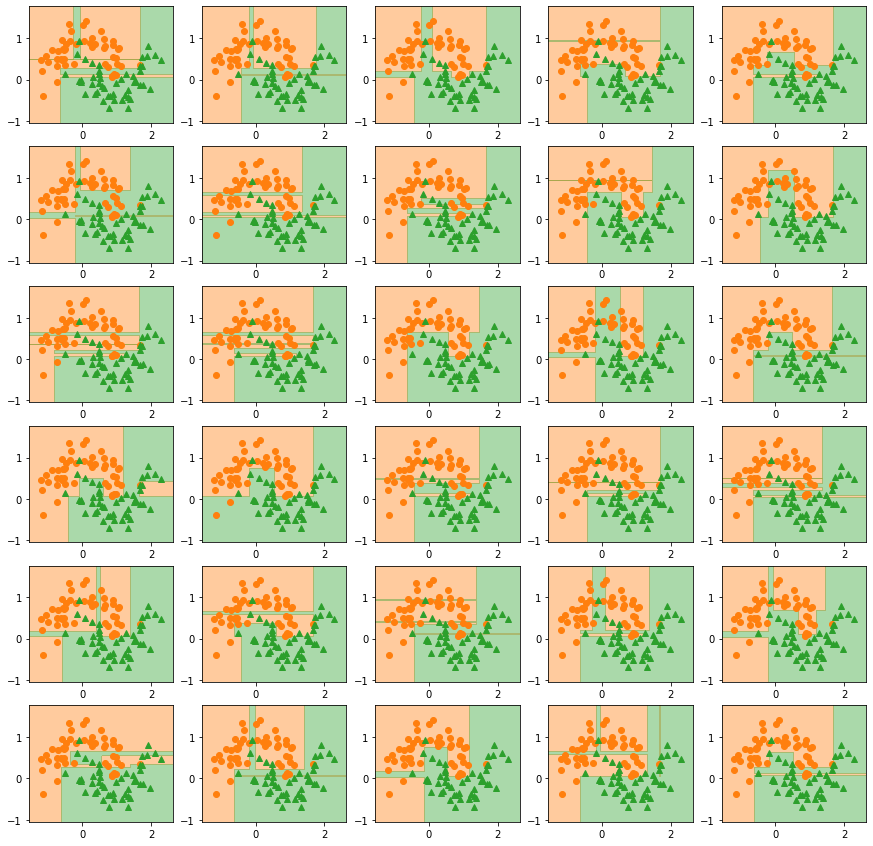

In [ ]:
# 그림으로 확인

eps = X.std()/2.  # 표준편차를 2로 나눈 작은 값을 입실론으로 설정
x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps  # min-입실론, max+입실론 해서 X의 모든 범위를 커버하도록 min, max설정
y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
xx = np.linspace(x_min, x_max, 1000)# linspace: 1차원 배열 만드는 함수. linspace(시작점, 끝점, 구간 내 숫자 개수)
# 즉 min~max 사이에 1000개 숫자 만들기
yy = np.linspace(y_min, y_max, 1000)
X1, X2 = np.meshgrid(xx, yy) # 그리드로 만들면 백만개의 grid 생김. 1000x1000
X_grid = np.c_[X1.ravel(), X2.ravel()] # fit 시키려면 X를 (N,D)형태로 넣어야 하니까 ravel 이용해서 쭉 펴줌. c_는 column 만드는 함수
# 즉, 백만x2 행렬이 만들어짐

# 30개 그림 그리기
cols= 5
fig, ax = plt.subplots(figsize=(15,15), nrows=6, ncols=cols)

for k in range(N):

    i = k // cols
    j = k % cols

    Z = ests[k].predict(X_grid) # ests는 30개의 예측기. 각 예측기에 대한 X_grid 예측값 
    print(Z.shape) 
    Z = Z.reshape(X1.shape) # 그림 그리려면 백만x2행렬을 다시 1000x1000행렬로 바꿔줘야함

    ax[i,j].plot(X[y==0][:, 0], X[y==0][:, 1], 'o', color='C1')
    ax[i,j].plot(X[y==1][:, 0], X[y==1][:, 1], '^', color='C2')
    ax[i,j].contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])

    ax[i,j].set_xlim(x_min, x_max)
    ax[i,j].set_ylim(y_min, y_max)

plt.show()

In [ ]:
X_grid.shape

(1000000, 2)

In [ ]:
# 각 개별 예측기의 결과 모으기
# X_grid: (1000000, 2)
# pred_i : (1000000, 30) => 백만개에 대해 30개씩 예측했으니까 

pred_i = np.r_[ [ests[i].predict(X_grid) for i in range(N)] ].T # 1번 예측기에 대해 X_grid 예측, 2번 예측기에 대해 X_grid 예측... => 행이 X_grid 열이 각 예측기
pred_i.shape

(1000000, 30)

- (1000000, 30)짜리 행렬로 예측이 쭈욱 됨.
  
  따라서 한 행마다 결정트리 30개로 예측한 30개의 예측값이 들어가게 되는데, 다수결에 의해서 행마다 최종 예측값을 출력함.

- (1,1,1,0,0,0,1,1,1,1,1, ... 30개) => 1

  이런 식으로 백만개의 행이 있는 것임

- 이거를 백만번 for 루프 돌리기 위해 bincount함수 사용


In [ ]:
np.bincount([1,1,0,0,0,1,1]) # 바이너리 카운트. 0이 3개 1이 4개

array([3, 4])

In [ ]:
print("0번 샘플에 대한 30개 예측", pred_i[0])
print("0과 1로 묶어 세면", np.bincount(pred_i[0]))
print("최종 판단은", np.argmax(np.bincount(pred_i[0])))
print()
print(f"{1000000-1}번 샘플에 대한 30개 예측", pred_i[1000000-1])
print("0과 1로 묶어 세면", np.bincount(pred_i[1000000-1]))
print("최종 판단은", np.argmax(np.bincount(pred_i[1000000-1])))

0번 샘플에 대한 30개 예측 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0]
0과 1로 묶어 세면 [27  3]
최종 판단은 0

999999번 샘플에 대한 30개 예측 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0과 1로 묶어 세면 [ 0 30]
최종 판단은 1


In [ ]:
# 각 개별 예측기의 결과 정리하기 (다수결 투표)
pred_ensemble = np.array([ np.argmax(np.bincount(pred_i[i]))
                          for i in range(pred_i.shape[0]) ])  # 모든 샘플에 대해서 구하기

In [ ]:
pred_ensemble.shape

(1000000,)

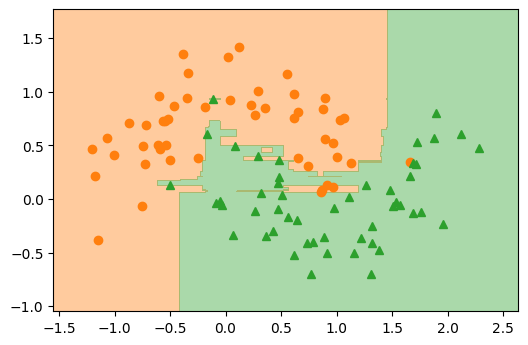

In [ ]:
# 그림으로 확인
eps = X.std()/2.
x_min, x_max = X[:, 0].min()-eps, X[:, 0].max()+eps
y_min, y_max = X[:, 1].min()-eps, X[:, 1].max()+eps
xx = np.linspace(x_min, x_max, 1000)
yy = np.linspace(y_min, y_max, 1000)
X1, X2 = np.meshgrid(xx, yy)
X_grid = np.c_[X1.ravel(), X2.ravel()]

Z = pred_ensemble
Z = Z.reshape(X1.shape)

fig = plt.figure(dpi=100)
ax = plt.axes()

ax.plot(X[y==0][:,0], X[y==0][:,1], 'o', color='C1')
ax.plot(X[y==1][:,0], X[y==1][:,1], '^', color='C2')
ax.contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plt.show()

#### sklearn 이용

In [ ]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
# 모델 생성과 fit
bagging_tree = BaggingClassifier( base_estimator=DecisionTreeClassifier(max_depth=5),
                                 n_estimators=N, random_state=100 ).fit(X, y)

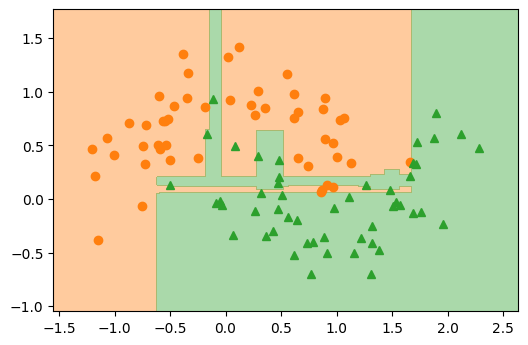

In [ ]:
# 그림으로 확인
eps = X.std()/2.
x_min, x_max = X[:, 0].min()-eps, X[:, 0].max()+eps
y_min, y_max = X[:, 1].min()-eps, X[:, 1].max()+eps
xx = np.linspace(x_min, x_max, 1000)
yy = np.linspace(y_min, y_max, 1000)
X1, X2 = np.meshgrid(xx, yy)
X_grid = np.c_[X1.ravel(), X2.ravel()]

Z = bagging_tree.predict(X_grid)
Z = Z.reshape(X1.shape)

fig = plt.figure(dpi=100)
ax = plt.axes()

ax.plot(X[y==0][:,0], X[y==0][:,1], 'o', color='C1')
ax.plot(X[y==1][:,0], X[y==1][:,1], '^', color='C2')
ax.contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plt.show()

# 조금 과적합 되는듯

### Random Forest

- 배깅의 대표 알고리즘
- 결정트리는 과대적합이 쉽게 되는 경향이 있음
- 각기 다른 방식으로 과대적합 되는 결정트리를 여러개 만들어서 각 결과를 평균하여 최종 결과 생성
- 트리를 여러개 만들 때 서로 다른 특성이 다른 트리를 만들어야 하므로 무작위성을 주입
    - data set에서 샘플을 매번 무작위로 선택(Bagging)+분할 특성을 무작위로 선택
- 즉, 각 트리를 더 독립적으로 만들기 위해 배깅 방법에 분할 특성까지 무작위로 선택해서 나누는 방식
- `max_feature`속성으로 무작위 선택에서 고려할 feature 수를 지정
    - `auto`: max_features=sqrt(n_features)
    - `sqrt`: max_features=sqrt(n_features) (same auto)
    - `log2`: max_features=log2(n_features)
    - `None`: max_features=n_features
- 위 항목처럼 전체 특성에서 무작위로 `max_feature`에 지정된 개수만큼 고른 후 그 중에 가장 좋은 특성을 탐색함.

장단점
- 매개변수를 많이 튜닝하지 않아도 기본적으로 잘 동작
- 트리기반 알고리즘으로 데이터의 스케일링 필요없음
- 각 개별 트리가 독립적으로 학습되므로 병렬화 시켜 학습속도 높일 수 있음
- 예측시 모든 트리에 대한 예측값을 계산해야 하므로 예측 속도가 선형 모델에 비해 느리고 메모리도 많이 소요


#### 학습

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# 학습하기
N = 5 # 예측기 수

forest = RandomForestClassifier(n_estimators=N, random_state=2)
forest.fit(X, y)

RandomForestClassifier(n_estimators=5, random_state=2)

- `estimators_` 속성으로 개별 트리 그리기

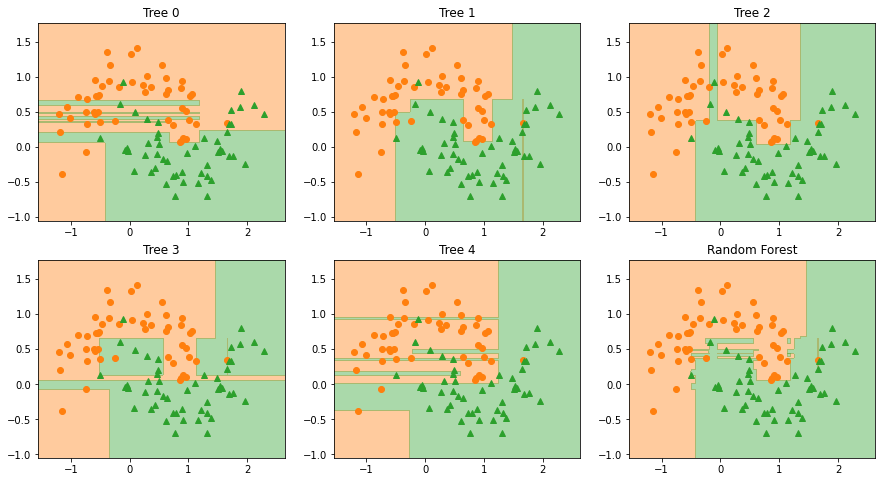

In [ ]:
eps = X.std() / 2.
x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
xx = np.linspace(x_min, x_max, 1000)
yy = np.linspace(y_min, y_max, 1000)
X1, X2 = np.meshgrid(xx, yy)
X_grid = np.c_[X1.ravel(), X2.ravel()]

cols=3
fig, ax = plt.subplots(figsize=(15,8), nrows=2, ncols=cols)

for n in range(N+1):
    i = n // cols
    j = n % cols
    
    ###############################################
    # [+]
    # estimators_로 그림그리기
    if n < N:
        Z = forest.estimators_[n].predict(X_grid)
        ax[i,j].set_title(f"Tree {n}")
    else:
        Z = forest.predict(X_grid)
        ax[i,j].set_title(f"Random Forest")
    ###############################################

    Z = Z.reshape(X1.shape)

    ax[i,j].plot(X[y==0][:, 0], X[y==0][:, 1], 'o', color='C1')
    ax[i,j].plot(X[y==1][:, 0], X[y==1][:, 1], '^', color='C2')
    ax[i,j].contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])

    ax[i,j].set_xlim(x_min, x_max)
    ax[i,j].set_ylim(y_min, y_max)

plt.show()

##### 직접 예측 만들기

$$
\hat{k} = \underset{k}{\text{argmax}} \frac{1}{N} \sum_i^N P_i(C_k | \mathbf{x})
$$

- 위 식에서 $i$는 개별 예측기
-  인덱스 $P_i(C_k | \mathbf{x})$는 $i$번째 예측기가 샘플 $\mathbf{x}$에 대해 $k$번째 클래스라고 예측한 확률

In [ ]:
X_grid.shape

(1000000, 2)

In [ ]:
foo = np.array([[1,2,3],
                [4,5,6]])
foo.max(axis=0)

array([4, 5, 6])

In [ ]:
# 모든 테스트 포인트에서 예측 확률 구하기
all_pred_proba = np.array([ forest.estimators_[i].predict_proba(X_grid) for i in range(N) ])
print(all_pred_proba.shape) # (5, 1000000, 2) N=5, 1000000개의 test 포인트, 특성 2개에 속할 확률
all_pred_proba_mean = all_pred_proba.mean(axis=0)
Z = all_pred_proba_mean.argmax(axis=1)
print(Z.shape) # (1000000,)
print(Z) # 두 특성 중 어디에 속할지

(5, 1000000, 2)
(1000000,)
[0 0 0 ... 1 1 1]


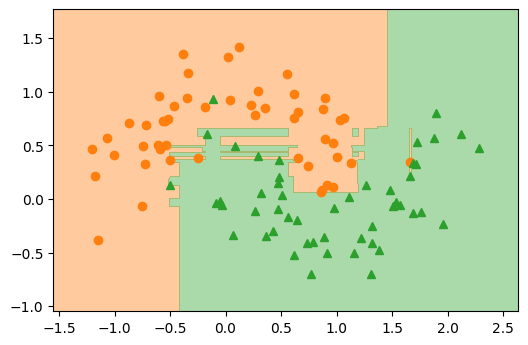

In [ ]:
# 그림으로 확인
eps = X.std() / 2.
x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
xx = np.linspace(x_min, x_max, 1000)
yy = np.linspace(y_min, y_max, 1000)
X1, X2 = np.meshgrid(xx, yy)
X_grid = np.c_[X1.ravel(), X2.ravel()]

Z = Z.reshape(X1.shape)

fig = plt.figure(dpi=100)
ax = plt.axes()

ax.plot(X[y==0][:,0], X[y==0][:,1], 'o', color='C1')
ax.plot(X[y==1][:,0], X[y==1][:,1], '^', color='C2')
ax.contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plt.show()

### 엑스트라 트리 Extremly Randomized Trees
- 보통 랜덤 포레스트는 분할에 사용할 특성을 무작위로 선택하고 선택된 특성에 대해서 최적의 분할값을 탐색
- 여기에 무작위성을 더 주입하기 위해 무작위로 선택된 특성의 분할값도 무작위로 선택하여 나누고 그 중 제일 좋은 분할을 선택하는 트리

장단점
- 최적의 분할값을 모두 서치해서 찾지 않기 때문에 속도 빠름
- 랜덤포레스트와 비교했을 때 어떤 것이 더 좋은 결과를 낼 지 알 수 없으므로 해봐야 함..

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
# 학습하기
extree = ExtraTreesClassifier(n_estimators=N, random_state=2)
extree.fit(X, y)

ExtraTreesClassifier(n_estimators=5, random_state=2)

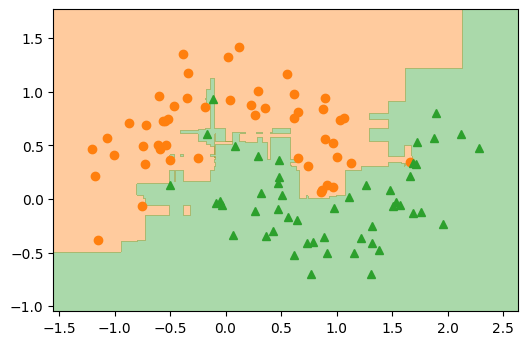

In [ ]:
eps = X.std() / 2.
x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
xx = np.linspace(x_min, x_max, 1000)
yy = np.linspace(y_min, y_max, 1000)
X1, X2 = np.meshgrid(xx, yy)
X_grid = np.c_[X1.ravel(), X2.ravel()]

Z = extree.predict(X_grid) # 예측값
Z = Z.reshape(X1.shape)

fig = plt.figure(dpi=100)
ax = plt.axes()

ax.plot(X[y==0][:,0], X[y==0][:,1], 'o', color='C1')
ax.plot(X[y==1][:,0], X[y==1][:,1], '^', color='C2')
ax.contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plt.show()

## 부스트 Boost

### 그래디언트 부스트 Gradient Boost

-  순차적으로 예측기를 만들어 나가되 앞 예측기가 틀린 오차를 학습데이터로 뒤 예측기를 학습시키는 방식

- $m$번째 예측기 $F_m(x_i)$가 있을 때

- 손실 함수의 데이터에 대한 합을 다음처럼 정의, 여기서 $n$은 샘플 개수 

$$
\sum_{i=1}^n L(y_i, F_m(x_i))
$$

- (1) 최초 예측기 $F_0(x)$를 다음을 만족하는 상수 $\gamma$로 설정

$$
F_0(x) = \underset{\gamma}{\text{argmin}} \sum_{i=1}^n L(y_i, \gamma)
$$

- (2) $m$번째 예측기가 $m-1$번째 보다 좋으려면 $F_m(x)$는 $F_{m-1}(x)$를 다음처럼 수정해야 한다.




$$
F_m(x) = F_{m-1}(x) + \underset{h_m \in \mathcal{H}}{\text{argmin}} \left[ \sum_{i=1}^n L\left(y_i, F_{m-1}(x_i)+h_m(x_i)\right) \right]
$$

- 위 식은 약한 예측기 $h_m(x)$를 $F_{m-1}(x)$에 더했을 때 손실 함수 $L$이 가장 작아지게 하는 $h_m(x)$를 찾아서 $F_{m-1}(x)$에 더해준다는 의미

- 위 문제는 함수 $F_{m-1}(x)$를 수정해서 $L$을 줄여나가는 함수최적화 문제, 즉 변분법calculus of variations 문제가 됨

- 그런데 $h_m(x)$가 함수이므로 함수공간 $\mathcal{H}$를 전부 뒤져서 $\text{argmin}$하는 $h_m(x)$를 찾는 것은 불가능

- 따라서 다음 식처럼 경사하강법gradient descent method를 사용하여 최적화 과정을 거치게 됨

$$
\begin{aligned}
F_m(x) &= F_{m-1}(x) + \alpha_m \nabla_{F_{m-1}} L(y, F_{m-1}(x))
\end{aligned}
$$

- 위 식에서 $\alpha_m$은 스텝 사이즈, $ \nabla_{F_{m-1}}  L(y, F_{m-1}(x)) $는 $L$의 $F_{m-1}$에 대한 그래디언트

- $\nabla_{F_{m-1}} L(y_i, F_{m-1}(x_i)) $는 $F_{m-1}$이 정해지면 (그래디언트가 정의되는 위치) 결정되는 함수!

- 이 함수를 $h_m(x)$라 하자.

- $h_m(x)$는 함수이므로 요소가 무한개인 그래디언트 벡터로 생각하면 이해하기 편함

- 이제 $L(y_i, F_{m-1}(x))$를 다음처럼 정의하면

$$
\frac{1}{2} (y- F_{m-1}(x))^2
$$

- $F_{m-1}(x)$에 대한 미분은 다음과 같다.

$$
\nabla_{F_{m-1}} \left\{ \frac{1}{2} (y - F_{m-1}(x))^2 \right\} = F_{m-1}(x) - y
$$



- 이 그래디언트에 마이너스 곱하면

$$
-\nabla_{F_{m-1}} L(y, F_{m-1}(x)) =  y - F_{m-1}(x)
$$

- 결과적으로 마이너스 그래디언트가 $F_{m-1}$의 잔차가 됨.



- 정리하면 $L$에 대한 $F_{m-1}$의 마이너스 그래디언트는 함수값으로 $F_{m-1}(x)$의 잔차를 가지는 함수

$$
g_m(x) = y - F_{m-1}(x)
$$

- 하지만 다음처럼 함수값 $i$개만 알 수 있음

$$
g_m(x_i) = y_i - F_{m-1}(x_i)
$$

- 그래서 $F_{m-1}$의 잔차 $y_i - F_{m-1}(x_i)$를 출력으로 하는 (잔차를 학습데이터로 하는) 예측기 $h_m$을 그래디언트로 사용 (이런 이유로 pseudo response 또는 pseudo residual 이라 함)

- $h(x)$의 학습 가능한 매개변수를 $a_m$이라 하면 $h_m(x ; a_m)$에서

$$
a_m = \underset{a}{\text{argmin}} \sum_{i=1}^N (g_m(x_i) - h(x_i;a))^2 
$$

- 위 식은 예측기 $h_m$에 적용가능한 학습 방법으로 수행될 수 있음

- 최종적으로 경사하강법은 다음처럼 되고

$$
F_m(x) = F_{m-1}(x) + \alpha_m h_m(x; a_m)
$$

- $F_{m-1}(x)$이 그래디언트 $h_m(x)$에 의해 부스팅되어 더 좋은 $F_m(x)$이 되므로 그래디언트 부스트가 됨

#### 데이터 생성

In [ ]:
# 2차식으로 만든 데이터 셋 + 노이즈
np.random.seed(66)
X = np.random.rand(100,1)-0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

print(X.shape, y.shape)

(100, 1) (100,)


#### 데이터 확인

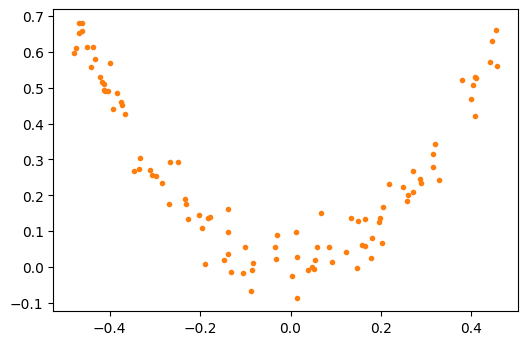

In [ ]:
fig = plt.figure(dpi=100)
ax = plt.axes()

ax.plot(X, y, '.', color='C1')

plt.show()

#### 학습과정 데모

In [ ]:
# 개별 학습기 로드
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

##### 0번 학습기

In [ ]:
# 아주 약한 학습기를 한번 학습 시킴
from sklearn.dummy import DummyRegressor

h0 = DummyRegressor(strategy = 'mean').fit(X, y)

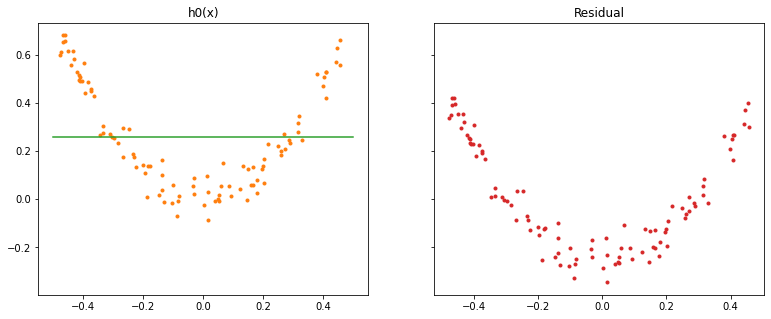

In [ ]:
# 예측하고 잔차를 구함
y_h0 = h0.predict(X) # prediction
r0 = y - y_h0 # residual

# 그림으로 확인
x = np.linspace(-0.5, 0.5, 1000)

fig, ax = plt.subplots(figsize=(13,5), nrows=1, ncols=2, sharey=True)

ax[0].plot(X, y, '.', color='C1')
ax[0].plot(x, h0.predict(x.reshape(-1,1)), color='C2')
ax[0].set_title('h0(x)')

ax[1].plot(X, r0, '.', color='C3')
ax[1].set_title('Residual')

plt.show()

In [ ]:
np.sum((y-y_h0)**2)/y.shape[0] # mse

0.04840590544774869

##### 1번 학습기

In [ ]:
# 두 번째 학습기 학습
# 아주 약한 학습기 한번 학습시키기
h1 = DecisionTreeRegressor(max_depth=2).fit(X, r0) # r0 <= 0번 학습기의 resid

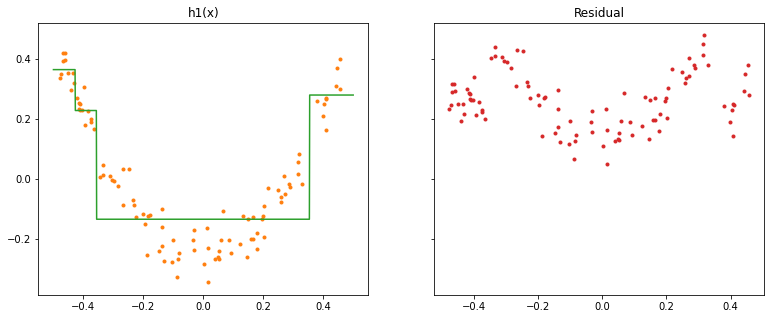

In [ ]:
# 예측하고 잔차 구하기
y_h1 = h1.predict(X) # prediction
r1 = y - y_h1 # resid

# 그림으로 확인
x = np.linspace(-0.5, 0.5, 1000)

fig, ax = plt.subplots(figsize=(13,5), nrows=1, ncols=2, sharey=True)

ax[0].plot(X, r0, '.', color='C1')
ax[0].plot(x, h1.predict(x.reshape(-1,1)), color='C2')
ax[0].set_title('h1(x)')

ax[1].plot(X, r1, '.', color='C3')
ax[1].set_title('Residual')

plt.show()

In [ ]:
np.sum((y - (y_h0+y_h1))**2)/y.shape[0] # mse

0.008670311093479245

##### 2번 학습기

In [ ]:
# 세 번째 학습기 학습
# 아주 약한 학습기
h2 = DecisionTreeRegressor(max_depth=2).fit(X, r1) # 2번 학습기의 잔차

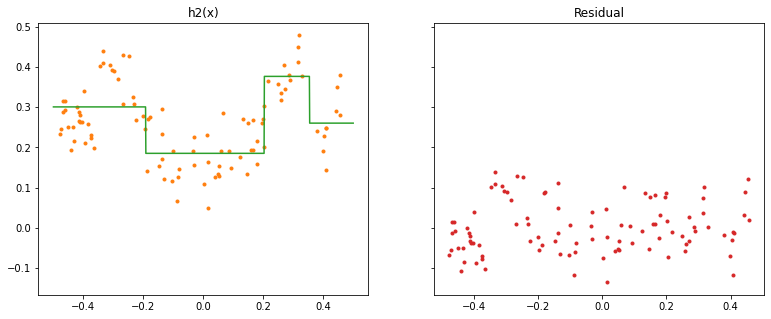

In [ ]:
# 예측하고 잔차 구하기
y_h2 = h2.predict(X)
r2 = r1-y_h2

# 그림으로 확인
x = np.linspace(-0.5, 0.5, 1000)

fig, ax = plt.subplots(figsize=(13,5), nrows=1, ncols=2, sharey=True)

ax[0].plot(X, r1, '.', color='C1')
ax[0].plot(x, h2.predict(x.reshape(-1,1)), color='C2')
ax[0].set_title('h2(x)')

ax[1].plot(X, r2, '.', color='C3')
ax[1].set_title('Residual')

plt.show()


In [ ]:
np.sum((y - (y_h0+y_h1+y_h2))**2)/y.shape[0] # mse
# 작아져야 하는데.. 커져버림..

0.07191526924650271

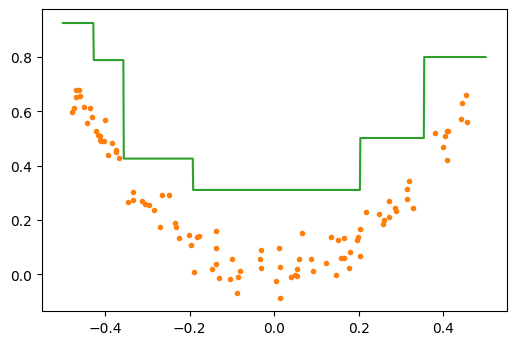

In [ ]:
# 예측기 세 개 더하기
pred = h0.predict(x.reshape(-1,1)) + h1.predict(x.reshape(-1,1)) + h2.predict(x.reshape(-1,1))

fig = plt.figure(dpi=100)
ax = plt.axes()

ax.plot(X, y, '.', color='C1')
ax.plot(x, pred, color='C2')

plt.show()

#### 학습

In [ ]:
# 그래드언트 부스팅 직접 만들기

# 위 알고리즘 (1)에서처럼 상수로 첫 번째 예측기 정함, m = 0
# 보통 평균으로
H = [ y.mean() ]

M = 2 # 예측기 수 -> 55
lr = 1.0 # 학습률 또는 스탭 사이즈 -> 0.1

# 첫 번째 예측
Fm_1 = np.ones(X.shape[0])*H[0]

# 학습
for m in range(1, M+1): # 최초 더미 예측기 제외 후 M개 트리

    # residual 구하기
    r_im = y - Fm_1

    # 잔차 r_im에 대해 학습기 hm을 학습하여 H에 추가
    H.append( DecisionTreeRegressor(max_depth=2, random_state=100).fit(X, r_im) )
    # H.append( KNeighborsRegressor(n_neighbors=10).fit(X, r_im) )

    # F 업데이트
    Fm_1 += lr*H[-1].predict(X) # H[-1]: append된 학습기 중 가장 최근 학습기 

In [ ]:
# 예측하기
x = np.linspace(-0.5, 0.5, 1000)

# 전체 학습기 돌면서
for i in range(len(H)) :
    if i == 0 :
        # 첫 번째 학습기는 상수만 출력하므로 모두 같은 값이니까
        pred = np.ones_like(x)*H[i]
    else :
        # 두 번째 부터는 학습률을 사용하여 업데이트
        pred += lr*H[i].predict(x.reshape(-1,1))

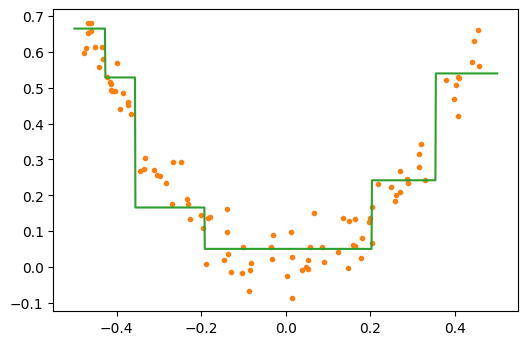

In [ ]:
fig = plt.figure(dpi=100)
ax = plt.axes()

ax.plot(X, y , '.', color='C1')
ax.plot(x, pred, color='C2')

plt.show()

##### sklearn 이용

- 개별 학습기는 무조건 트리 기반으로 구현!! 

In [ ]:
# 모델 로드
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
# 모델 생성과 fit
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=M, learning_rate=lr)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=2)

In [ ]:
# 예측
pred_sk = gbrt.predict(x.reshape(-1,1))

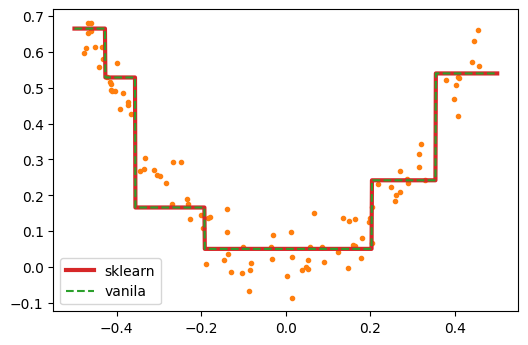

In [ ]:
fig = plt.figure(dpi=100)
ax = plt.axes()

ax.plot(X, y , '.', color='C1')
ax.plot(x, pred_sk, color='C3', lw=3, label='sklearn')
ax.plot(x, pred, '--', color='C2', label='vanila')

ax.legend()
plt.show()

##### 최적 트리수 찾기

- `staged_predict()`: 트리를 하나씩 추가시키면서 생성되는 예측을 되돌림

In [ ]:
# 데이터 split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)

In [ ]:
# 모델 생성과 fit
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=50, learning_rate=lr)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=50)

In [ ]:
# staged_predict 사용
from sklearn.metrics import mean_squared_error

errors = [ mean_squared_error(y_test,y_pred) for y_pred in gbrt.staged_predict(X_test) ]

best_n_est = np.argmin(errors)
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_est, learning_rate=lr)

gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=2)

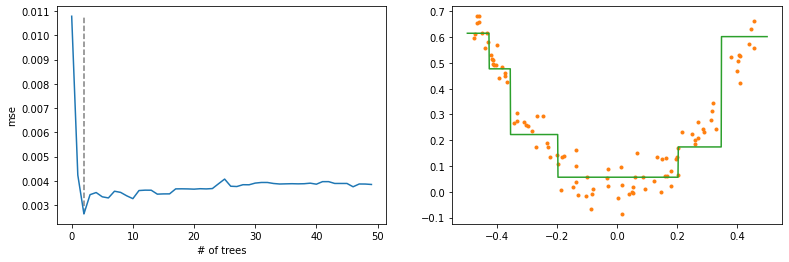

2


In [ ]:
# 그림으로 확인
fig, ax = plt.subplots(figsize=(13,4), nrows=1, ncols=2)

ax[0].plot(errors)
# ax[0].set_ylim([0.002, 0.0035])
ax[0].vlines(best_n_est, min(errors), max(errors), ls='--', alpha=0.5)
ax[0].set_xlabel('# of trees')
ax[0].set_ylabel('mse')

ax[1].plot(X, y , '.', color='C1')
ax[1].plot(x, gbrt_best.predict(x.reshape(-1,1)), color='C2')

plt.show()

print(best_n_est)


## 실제 데이터

### 분류:유방암 데이터

In [ ]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target, random_state=100)

#### 배깅

In [ ]:
from sklearn.ensemble import BaggingClassifier

bagging_tree = BaggingClassifier( base_estimator = DecisionTreeClassifier(max_depth=5),
                                 n_estimators=100, random_state=100).fit(X_train, y_train)

In [ ]:
print(f"training set Acc.: {bagging_tree.score(X_train, y_train):.3f}")
print(f"test set Acc.: {bagging_tree.score(X_test, y_test):.3f}")

training set Acc.: 0.998
test set Acc.: 0.958


#### 랜덤포레스트

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=100).fit(X_train, y_train)

In [ ]:
print(f"training set Acc.: {RF.score(X_train, y_train):.3f}")
print(f"test set Acc.: {RF.score(X_test, y_test):.3f}")

training set Acc.: 0.998
test set Acc.: 0.972


#### 그래디언트 부스팅

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbct = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=5).fit(X_train, y_train)

In [ ]:
print(f"training set Acc.: {gbct.score(X_train, y_train):.3f}")
print(f"test set Acc.: {gbct.score(X_test, y_test):.3f}")

training set Acc.: 1.000
test set Acc.: 0.937


### 분류2: 2Gaussian

In [ ]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_twoclass.html#sphx-glr-auto-examples-ensemble-plot-adaboost-twoclass-py

from sklearn.datasets import make_gaussian_quantiles

X1, y1 = make_gaussian_quantiles(
    cov=2.0, n_samples=200, n_features=2, n_classes=2, random_state=1
)
X2, y2 = make_gaussian_quantiles(
    mean=(3, 3), cov=1.5, n_samples=300, n_features=2, n_classes=2, random_state=1
)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, -y2 + 1))

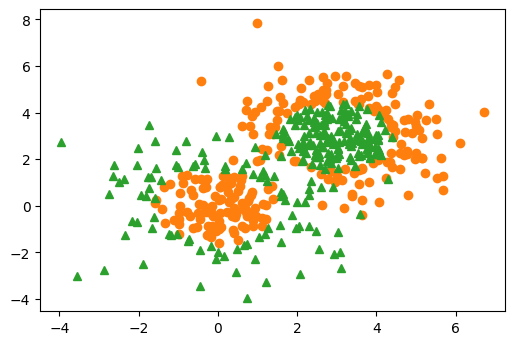

In [ ]:
fig = plt.figure(dpi=100)
ax = plt.axes()

ax.plot(X[y==0][:, 0], X[y==0][:, 1], 'o', color='C1')
ax.plot(X[y==1][:, 0], X[y==1][:, 1], '^', color='C2')

plt.show()

In [ ]:
# 그래디언트 부스팅
gbct = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=100).fit(X, y)

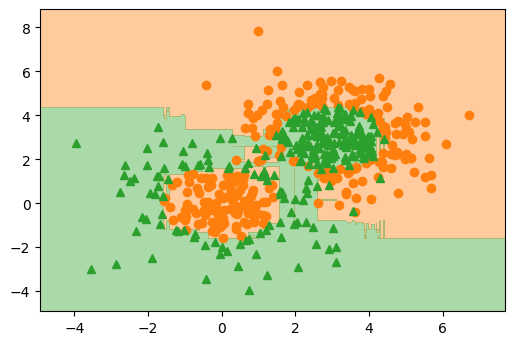

In [ ]:
# 그림으로 확인[*]
eps = X.std() / 2.
x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
xx = np.linspace(x_min, x_max, 500)
yy = np.linspace(y_min, y_max, 500)
X1, X2 = np.meshgrid(xx, yy)
X_grid = np.c_[X1.ravel(), X2.ravel()]

Z = gbct.predict(X_grid)
Z = Z.reshape(X1.shape)

fig = plt.figure(dpi=100)
ax = plt.axes()

ax.plot(X[y==0][:, 0], X[y==0][:, 1], 'o', color='C1')
ax.plot(X[y==1][:, 0], X[y==1][:, 1], '^', color='C2')

ax.contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plt.show()

#### 회귀: 가상곡선

In [ ]:
# 데이터 로드
D = np.load('/content/data_1d.npz')

x = D['x']
t = D['t']
X_train = D['X_train']
y_train = D['Y_train']
X_test = D['X_test']
y_test = D['Y_test']


In [ ]:
print(X_train)
print(y_train)
print('='*70)
print(X_train.shape, y_train.shape)

[0.1        0.36666667 0.63333333 0.9        1.16666667 1.43333333
 1.7        1.96666667 2.23333333 2.5       ]
[ 2.59432183  4.1193642   1.05620327  0.03328507  1.14306958  1.72283378
  1.26575323  0.10017529  0.0357391  -0.08008968]
(10,) (10,)


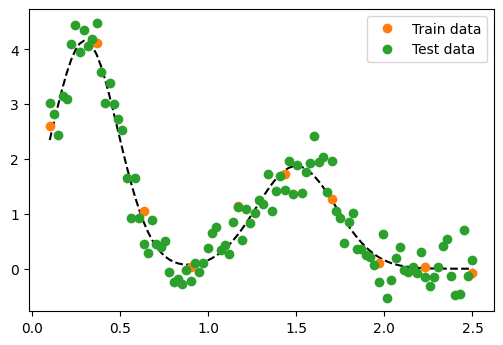

In [ ]:
fig = plt.figure(dpi=100)
ax = plt.axes()

ax.plot(x, t, '--', color='k')
ax.plot(X_train, y_train, 'o', color='C1', label='Train data')
ax.plot(X_test, y_test, 'o', color='C2', label='Test data')

ax.legend()
ax.grid(False)

plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
# train 그래디언트 모델 fit
gbrt_train = GradientBoostingRegressor(n_estimators=20, max_depth=2,
                                       random_state=100, learning_rate=0.5).fit(X_train.reshape(-1,1), y_train)

In [ ]:
# test 그래디언트 모델 fit
gbrt_test = GradientBoostingRegressor(n_estimators=100, max_depth=2,
                                      random_state=100, learning_rate=0.5).fit(X_test.reshape(-1,1), y_test)

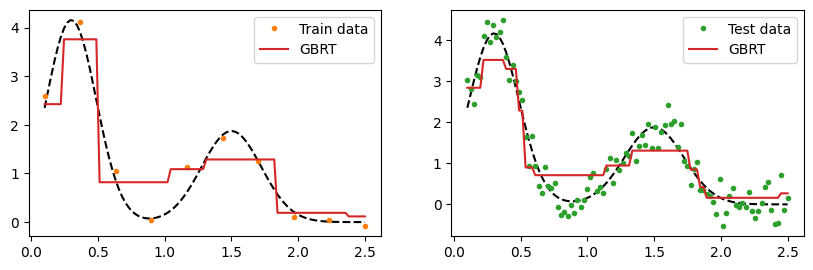

In [ ]:
# 그림으로 확인[*]
fig, ax = plt.subplots(figsize=(10,3), nrows=1, ncols=2, dpi=100)

ax[0].plot(x, t, '--', color='k')
ax[0].plot(X_train, y_train, '.', color='C1', label='Train data')
ax[0].plot( x, gbrt_train.predict(x.reshape(-1,1)), color='C3', label='GBRT' )
ax[0].legend()


ax[1].plot(x, t, '--', color='k')
ax[1].plot(X_test, y_test, '.', color='C2', label='Test data')
ax[1].plot( x, gbrt_test.predict(x.reshape(-1,1)), color='C3', label='GBRT' )
ax[1].legend()


plt.show()

- 러닝 레이트가 작아지거나 예측기 수를 줄이면 밋밋해짐